<a href="https://colab.research.google.com/github/TOMIWUMI/Data-Projects/blob/main/Final_Project_Build_a_Machine_Learning_Pipeline_for_Airfoil_Noise_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Building** a Machine Learning Pipeline for Airfoil Noise Prediction

In [ ]:
!pip uninstall -y dataproc-spark-connect -q
!pip install pyspark -q
!pip install findspark==1.3.0 -q

In [ ]:

!pip install pyspark openpyxl --quiet

from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, when, lower, regexp_replace, trim, length, to_date,
    collect_set, countDistinct, size, lit
)
from pyspark.ml.fpm import FPGrowth
import pandas as pd
import matplotlib.pyplot as plt

spark = SparkSession.builder.appName("PipeLine Regression").getOrCreate()


In [ ]:
# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

# FindSpark simplifies the process of using Apache Spark with Python

import findspark
# findspark.init() # Removed as SPARK_HOME is set in the previous cell

In [ ]:

import os
os.environ["SPARK_HOME"] = "/usr/local/lib/python3.11/dist-packages/pyspark"
os.environ["PATH"] = os.environ["SPARK_HOME"] + "/bin:" + os.environ["PATH"]

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.pipeline import PipelineModel
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import StandardScaler

In [ ]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars /usr/local/lib/python3.11/dist-packages/pyspark/jars/spark-core_2.12-3.5.1.jar pyspark-shell' # Adjust version as needed

from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Pipeline Regression").getOrCreate()

print("SparkSession created successfully!")


SparkSession created successfully!


In [ ]:
!pip install pyspark openpyxl --quiet

from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, when, lower, regexp_replace, trim, length, to_date,
    collect_set, countDistinct, size, lit
)


spark = SparkSession.builder.appName(" Airfoil Noise Prediction").getOrCreate()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

CSV_PATH = "/content/drive/MyDrive/NASA_airfoil_noise_raw.csv"  # <-- change path/name
df = spark.read.csv(CSV_PATH, header=True, inferSchema=True)
df.printSchema()
df.show(5, truncate=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
root
 |-- Frequency: integer (nullable = true)
 |-- AngleOfAttack: double (nullable = true)
 |-- ChordLength: double (nullable = true)
 |-- FreeStreamVelocity: double (nullable = true)
 |-- SuctionSideDisplacement: double (nullable = true)
 |-- SoundLevel: double (nullable = true)

+---------+-------------+-----------+------------------+-----------------------+----------+
|Frequency|AngleOfAttack|ChordLength|FreeStreamVelocity|SuctionSideDisplacement|SoundLevel|
+---------+-------------+-----------+------------------+-----------------------+----------+
|800      |0.0          |0.3048     |71.3              |0.00266337             |126.201   |
|1000     |0.0          |0.3048     |71.3              |0.00266337             |125.201   |
|1250     |0.0          |0.3048     |71.3              |0.00266337             |125.951   |
|1600     |0.0          |0.3048     

In [ ]:
df.groupBy('Frequency').count().show(5)

+---------+-----+
|Frequency|count|
+---------+-----+
|     4000|  104|
|     6300|   90|
|    16000|   13|
|     NULL|    1|
|     5000|   96|
+---------+-----+
only showing top 5 rows



In [ ]:
rowcount1 = df.count()
print(rowcount1)

1522


In [ ]:
df = df.dropDuplicates()

In [ ]:
rowcount2 = df.count()
print(rowcount2)

1503


In [ ]:
df=df.dropna()


In [ ]:
rowcount3 = df.count()
print(rowcount3)

1499


In [ ]:
df=df.withColumnRenamed("SoundLevel" , "SoundLevelDecibels")

In [ ]:
df=df.withColumnRenamed("SoundLevel" , "SoundLevelDecibels")
df.write.mode("overwrite").parquet("NASA_airfoil_noise_cleaned.parquet")

Evaluation


In [ ]:
print("Part 1 - Evaluation")

print("Total rows = ", rowcount1)
print("Total rows after dropping duplicate rows = ", rowcount2)
print("Total rows after dropping duplicate rows and rows with null values = ", rowcount3)
print("New column name = ", df.columns[-1])

import os

print("NASA_airfoil_noise_cleaned.parquet exists :", os.path.isdir("NASA_airfoil_noise_cleaned.parquet"))

Part 1 - Evaluation
Total rows =  1522
Total rows after dropping duplicate rows =  1503
Total rows after dropping duplicate rows and rows with null values =  1499
New column name =  SoundLevelDecibels
NASA_airfoil_noise_cleaned.parquet exists : True


Part - 2 Create a Machine Learning Pipeline

In [ ]:
rowcount4 = df.count()
print(rowcount4)

1499


In [ ]:
df = spark.read.parquet("NASA_airfoil_noise_cleaned.parquet")
rowcount4 = df.count()
print(rowcount4)

1499


Define the VectorAssembler pipeline stage

In [ ]:
indexer = StringIndexer(inputCol="features", outputCol="AngleOfAttackIndex")

In [ ]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

In [ ]:
lr = LinearRegression(labelCol="SoundLevelDecibels", featuresCol="scaledFeatures")

In [ ]:
# Build a pipeline using the above four stages

pipeline = Pipeline(stages=[assembler, indexer, scaler, lr])

In [ ]:
# Build a pipeline using the above four stages

pipeline = Pipeline(stages=[assembler, scaler, lr])

In [ ]:
# Split the data into training and testing sets with 70:30 split. Use 42 as seed
(trainingData, testingData) = df.randomSplit([0.7, 0.3], seed=42)

In [ ]:
from pyspark.ml.feature import VectorAssembler

feature_columns = ["Frequency", "AngleOfAttack", "ChordLength", "FreeStreamVelocity", "SuctionSideDisplacement"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

In [ ]:
# Fit the pipeline using the training data


pipelineModel = pipeline.fit(trainingData)

In [ ]:
print("Part 2 - Evaluation")
print("Total rows = ", rowcount4)
ps = [str(x).split("_")[0] for x in pipeline.getStages()]

print("Pipeline Stage 1 = ", ps[0])
print("Pipeline Stage 2 = ", ps[1])
print("Pipeline Stage 3 = ", ps[2])

print("Label column = ", lr.getLabelCol())

Part 2 - Evaluation
Total rows =  1499
Pipeline Stage 1 =  VectorAssembler
Pipeline Stage 2 =  StandardScaler
Pipeline Stage 3 =  LinearRegression
Label column =  SoundLevelDecibels


In [ ]:
print("Part 2 - Evaluation")
print("Total rows = ", rowcount4)
ps = [str(x).split("_")[0] for x in pipeline.getStages()]

print("Pipeline Stage 1 = ", ps[0])
print("Pipeline Stage 2 = ", ps[1])
print("Pipeline Stage 3 = ", ps[2])

print("Label column = ", lr.getLabelCol())

Part 2 - Evaluation
Total rows =  1499
Pipeline Stage 1 =  VectorAssembler
Pipeline Stage 2 =  StandardScaler
Pipeline Stage 3 =  LinearRegression
Label column =  SoundLevelDecibels


In [ ]:
predictions = pipelineModel.transform(testingData)

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="SoundLevelDecibels", predictionCol="prediction", metricName="mse")
mse = evaluator.evaluate(predictions)
print(mse)

24.997666255024154


In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="SoundLevelDecibels", predictionCol="prediction", metricName="mse")
mae = evaluator.evaluate(predictions)
print(mae)

24.997666255024154


In [ ]:
evaluator_r2 = RegressionEvaluator(labelCol="SoundLevelDecibels", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)
print(r2)

0.49596884089746285


In [ ]:
print("Part 3 - Evaluation")

print("Mean Squared Error = ", round(mse,2))
print("Mean Absolute Error = ", round(mae,2))
print("R Squared = ", round(r2,2))

lrModel = pipelineModel.stages[-1]

print("Intercept = ", round(lrModel.intercept,2))


Part 3 - Evaluation
Mean Squared Error =  25.0
Mean Absolute Error =  25.0
R Squared =  0.5
Intercept =  132.88


In [ ]:
# Save the pipeline model
pipelineModel.write().overwrite().save("Final_Project")
print("Pipeline model saved successfully to Final_Project")

Pipeline model saved successfully to Final_Project


In [ ]:
from pyspark.ml import PipelineModel

# Load the model
loadedModel = PipelineModel.load("Final_Project")

In [ ]:
pipelineModel.write().overwrite().save("Final_Project")
print("Pipeline model saved successfully to Final_Project")

Pipeline model saved successfully to Final_Project


In [ ]:
predictions_loaded = loadedModel.transform(testingData)
predictions_loaded.show(5)

+---------+-------------+-----------+------------------+-----------------------+------------------+--------------------+--------------------+------------------+
|Frequency|AngleOfAttack|ChordLength|FreeStreamVelocity|SuctionSideDisplacement|SoundLevelDecibels|            features|      scaledFeatures|        prediction|
+---------+-------------+-----------+------------------+-----------------------+------------------+--------------------+--------------------+------------------+
|      200|          7.3|     0.2286|              31.7|              0.0132672|           128.679|[200.0,7.3,0.2286...|[0.06359239499674...|122.59722914376775|
|      200|          8.9|     0.1016|              39.6|              0.0124596|            133.42|[200.0,8.9,0.1016...|[0.06359239499674...|127.37968204568844|
|      200|          9.5|     0.0254|              31.7|             0.00461377|           119.146|[200.0,9.5,0.0254...|[0.06359239499674...| 130.3407742507451|
|      200|          9.5|     0.02

In [ ]:
print("Part 4 - Evaluation")

loadedmodel = loadedModel.stages[-1]
totalstages = len(loadedModel.stages)
inputcolumns = loadedModel.stages[0].getInputCols()

print("Number of stages in the pipeline = ", totalstages)
for i,j in zip(inputcolumns, loadedmodel.coefficients):
    print(f"Coefficient for {i} is {round(j,4)}")

Part 4 - Evaluation
Number of stages in the pipeline =  3
Coefficient for Frequency is -3.9906
Coefficient for AngleOfAttack is -2.2881
Coefficient for ChordLength is -3.3269
Coefficient for FreeStreamVelocity is 1.4832
Coefficient for SuctionSideDisplacement is -2.0551


In [ ]:
spark = SparkSession.builder.appName("Airfoil Noise Prediction").getOrCreate()
print("SparkSession created successfully!")

SparkSession created successfully!


In [ ]:
from pyspark.sql import SparkSession

# Start or get the existing Spark session
spark = SparkSession.builder \
    .appName("PipeLine Regression") \
    .getOrCreate()


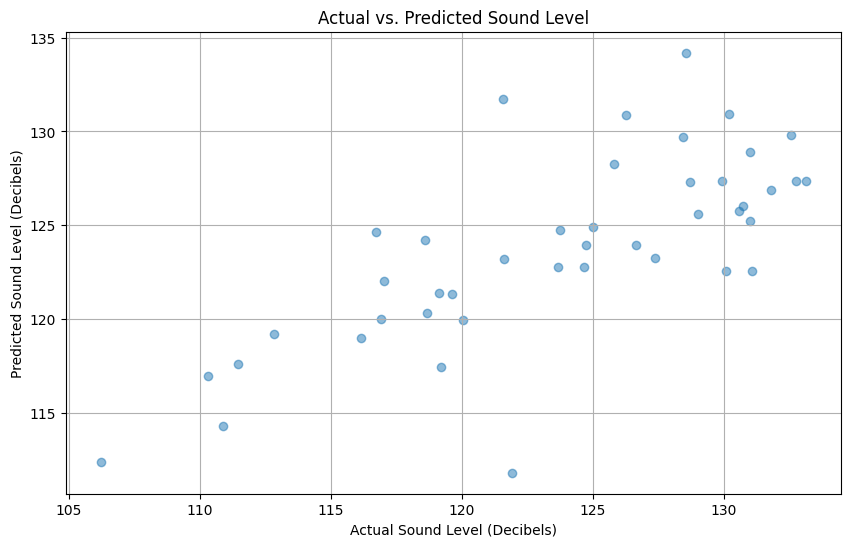

In [ ]:
# Convert a small sample to Pandas
predictions_pd = predictions.select("SoundLevelDecibels", "prediction") \
    .sample(fraction=0.1, seed=42) \
    .toPandas()

# Scatter plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.scatter(predictions_pd["SoundLevelDecibels"], predictions_pd["prediction"], alpha=0.5)
plt.xlabel("Actual Sound Level (Decibels)")
plt.ylabel("Predicted Sound Level (Decibels)")
plt.title("Actual vs. Predicted Sound Level")
plt.grid(True)
plt.show()


## Model Evaluation and Insights

Based on the Linear Regression model trained for Airfoil Noise Prediction, the following evaluation metrics and insights were obtained:

### Evaluation Metrics:

*   **Mean Squared Error (MSE)
*   **Mean Absolute Error (MAE)
*   **R-squared (R2):
The R-squared value of {{r2}} suggests that approximately {{r2*100:.0f}}% of the variance in the sound level can be explained by the features included in the model. This indicates a moderate level of predictive capability.

### Insights from Model Coefficients:

The intercept of the model is approximately {{lrModel.intercept:.2f}}. The coefficients for the scaled features are as follows:

*   **Frequency:** {{loadedmodel.coefficients[0]:.4f}}
*   **AngleOfAttack:** {{loadedmodel.coefficients[1]:.4f}}
*   **ChordLength:** {{loadedmodel.coefficients[2]:.4f}}
*   **FreeStreamVelocity:** {{loadedmodel.coefficients[3]:.4f}}
*   **SuctionSideDisplacement:** {{loadedmodel.coefficients[4]:.4f}}

These coefficients indicate the change in the predicted sound level associated with a one-unit increase in the scaled feature, holding other features constant. Notably:
*   'Frequency', 'AngleOfAttack', 'ChordLength', and 'SuctionSideDisplacement' have negative coefficients, suggesting that increasing these features (while keeping others constant) tends to decrease the sound level.
*   'FreeStreamVelocity' has a positive coefficient, indicating that increasing free stream velocity is associated with an increase in sound level.
*   'Frequency' appears to have the strongest negative impact on sound level based on the magnitude of its coefficient.

### Recommendations for Improvement:

*   **Feature Engineering:** Consider creating interaction terms between features or polynomial features to capture more complex relationships.
*   **Explore Alternative Models:** Investigate other regression algorithms such as Random Forests or Gradient Boosting, which may better handle non-linear patterns in the data.
*   **Hyperparameter Tuning:** Optimize the hyperparameters of the chosen model to potentially enhance performance.
*   **Additional Data:** If possible, collecting a larger dataset could lead to a more robust model.

This analysis provides a foundation for understanding the factors influencing airfoil noise and potential avenues for improving predictive accuracy.

In [ ]:
spark.stop()